$Saroj\ Sathish - ssathish$

$Suryanarayanan\ Balaji - suryanab$

In [1]:
import findspark
findspark.init()
findspark.find()

import pyspark
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("MQTT_dataset_IOT") \
    .getOrCreate()

In [2]:
from pyspark import SparkFiles

df1 = spark.read.csv(r"C:\Users\SAROJ SATHISH\Downloads\MMQT\train70_augmented.csv",header=True, inferSchema= True)
df2 = spark.read.csv(r"C:\Users\SAROJ SATHISH\Downloads\MMQT\test30_augmented.csv",header=True, inferSchema= True)

When we tried to read the complete dataset from postgres, it was giving errors due to memory problem. So we are using a subset of data in the same ratio of 70% and 30%. (## Piazza - use subset if giving error)

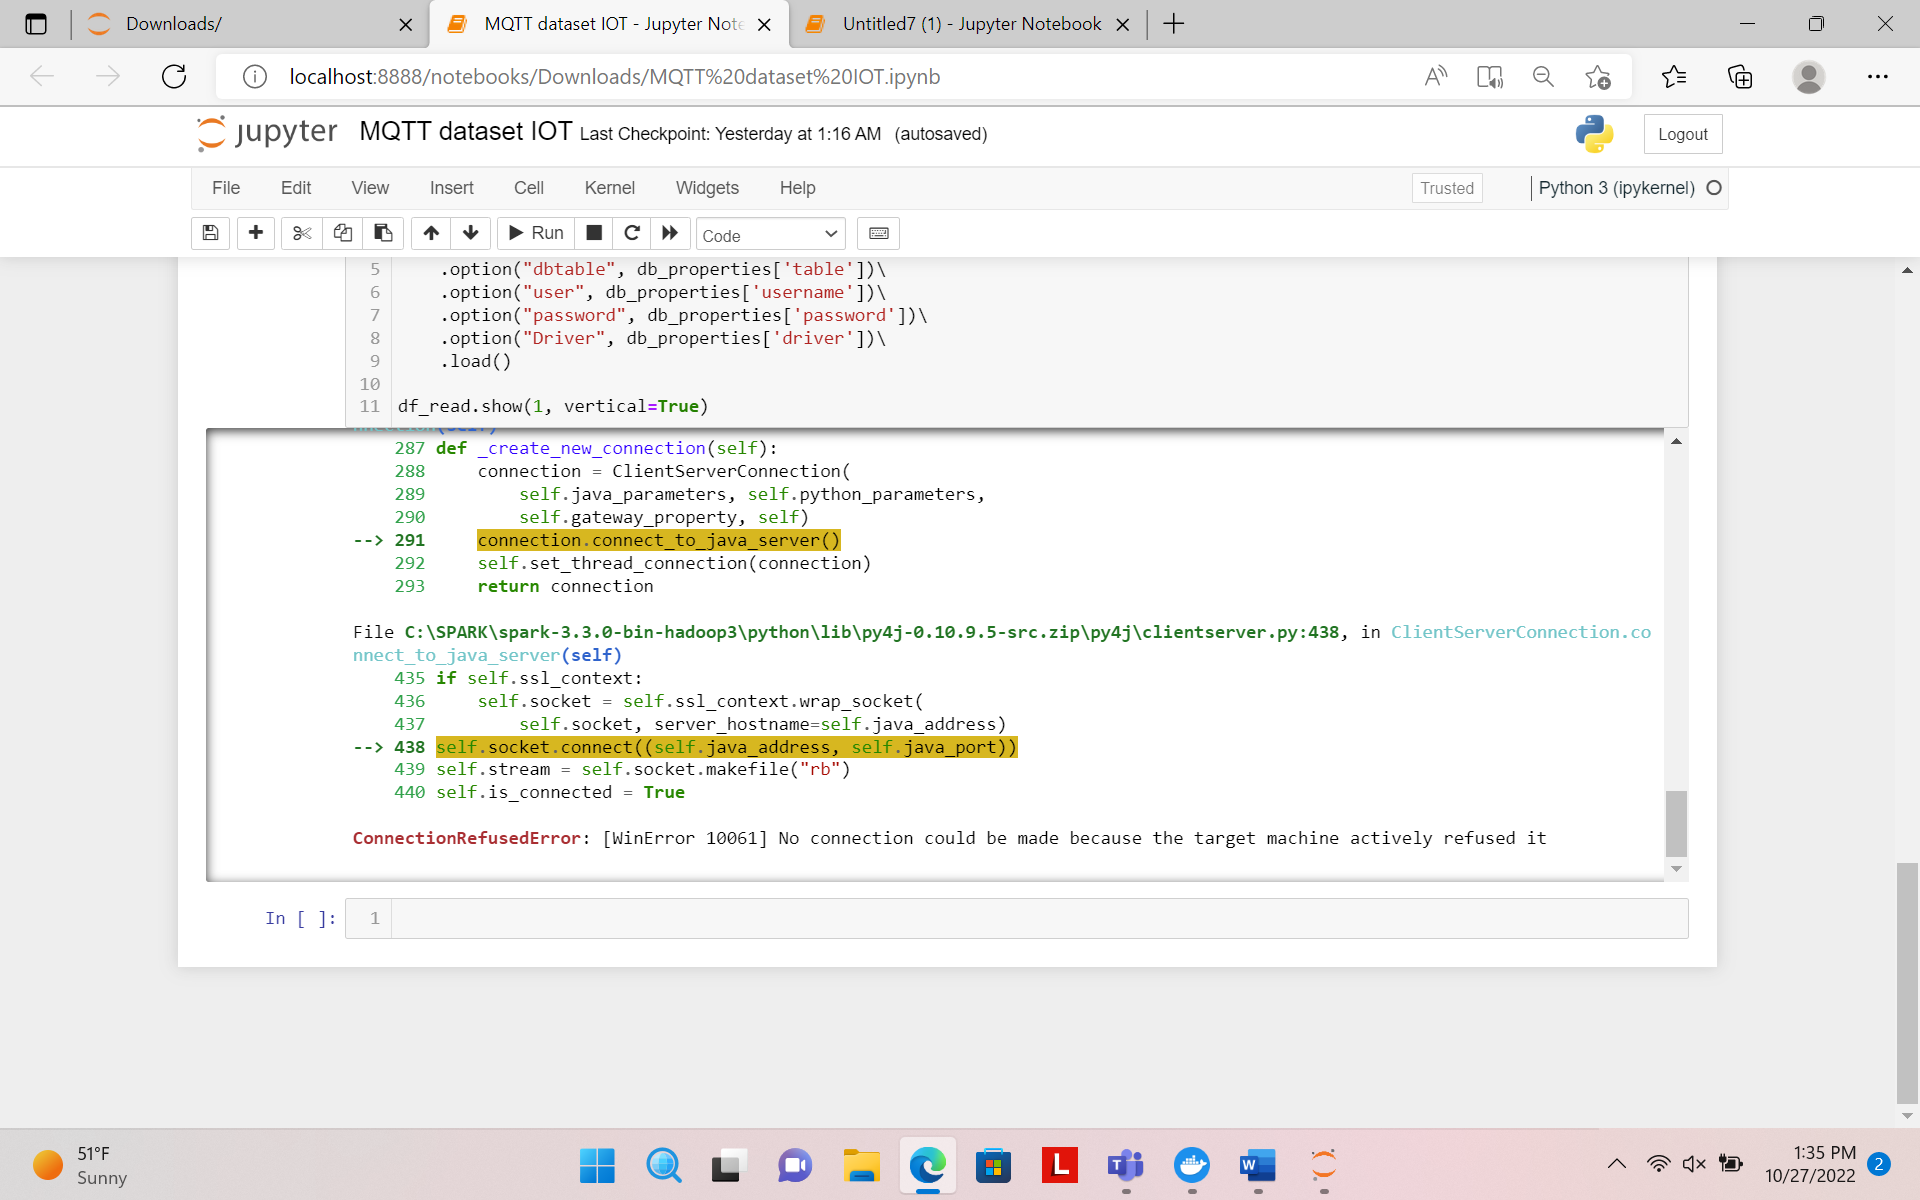

In [3]:
df3 = df1.limit(140000) ## Train dataset in ratio

df4 = df2.limit(60000)  ## Test dataset in ratio
df = df3.union(df4) ## combining both
df.printSchema()

root
 |-- tcp.flags: string (nullable = true)
 |-- tcp.time_delta: double (nullable = true)
 |-- tcp.len: integer (nullable = true)
 |-- mqtt.conack.flags: string (nullable = true)
 |-- mqtt.conack.flags.reserved: double (nullable = true)
 |-- mqtt.conack.flags.sp: double (nullable = true)
 |-- mqtt.conack.val: double (nullable = true)
 |-- mqtt.conflag.cleansess: double (nullable = true)
 |-- mqtt.conflag.passwd: double (nullable = true)
 |-- mqtt.conflag.qos: double (nullable = true)
 |-- mqtt.conflag.reserved: double (nullable = true)
 |-- mqtt.conflag.retain: double (nullable = true)
 |-- mqtt.conflag.uname: double (nullable = true)
 |-- mqtt.conflag.willflag: double (nullable = true)
 |-- mqtt.conflags: string (nullable = true)
 |-- mqtt.dupflag: double (nullable = true)
 |-- mqtt.hdrflags: string (nullable = true)
 |-- mqtt.kalive: double (nullable = true)
 |-- mqtt.len: double (nullable = true)
 |-- mqtt.msg: string (nullable = true)
 |-- mqtt.msgid: double (nullable = true)
 |-

Ingesting test and train to postgres table. Created a schmea of name "mqtt" in postgres before writing.

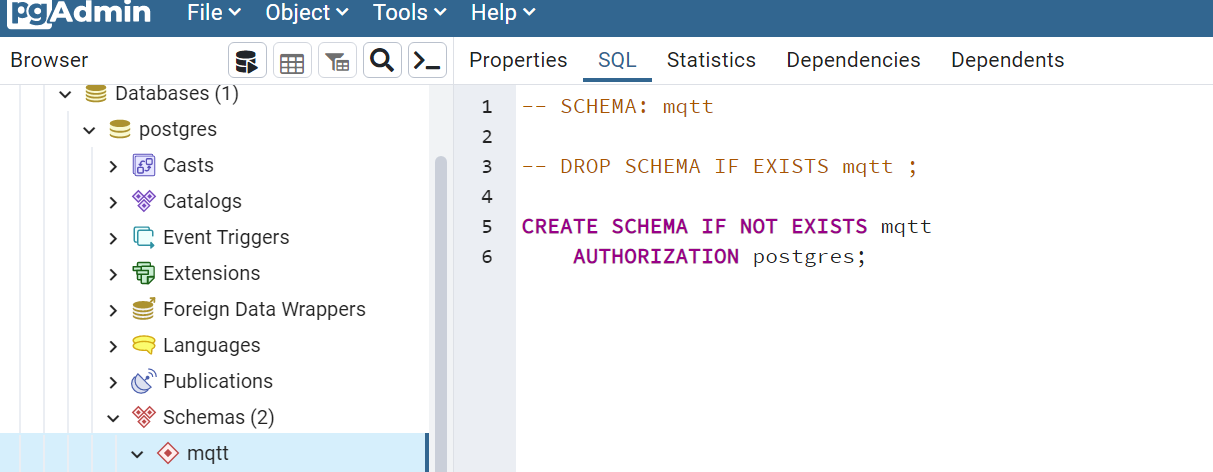

In [4]:
db_properties={}
db_properties['username']="postgres"
db_properties['password']="Redemption8!"
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "mqtt.mqtt_iot"


df.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()

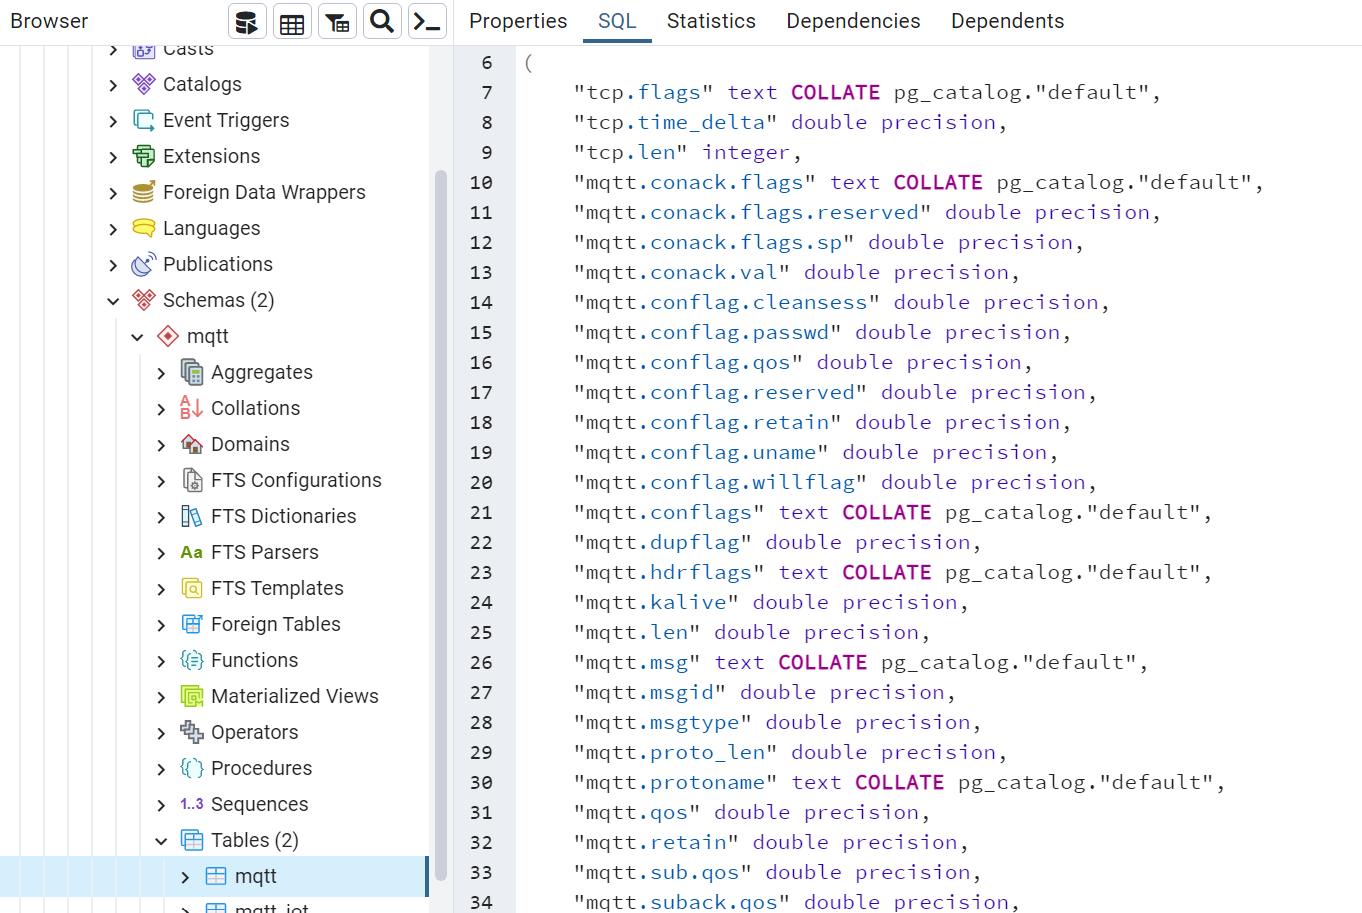

In [5]:
from pyspark.sql import SQLContext
df_read = spark.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

df_read.show(1, vertical=True)

-RECORD 0------------------------------------------
 tcp.flags                  | 0x00000010           
 tcp.time_delta             | 0.0                  
 tcp.len                    | 1460                 
 mqtt.conack.flags          | 0                    
 mqtt.conack.flags.reserved | 0.0                  
 mqtt.conack.flags.sp       | 0.0                  
 mqtt.conack.val            | 0.0                  
 mqtt.conflag.cleansess     | 0.0                  
 mqtt.conflag.passwd        | 0.0                  
 mqtt.conflag.qos           | 0.0                  
 mqtt.conflag.reserved      | 0.0                  
 mqtt.conflag.retain        | 0.0                  
 mqtt.conflag.uname         | 0.0                  
 mqtt.conflag.willflag      | 0.0                  
 mqtt.conflags              | 0                    
 mqtt.dupflag               | 1.0                  
 mqtt.hdrflags              | 0x0000003a           
 mqtt.kalive                | 0.0                  
 mqtt.len   

In [6]:
from pyspark.sql.functions import lit,length,mean

In [7]:
from pyspark.sql.functions import monotonically_increasing_id, when
dfn = df_read.withColumn("id",monotonically_increasing_id())

Created a new field "id" just for separating train and test. We could have added for train and test separtely before wrting into table. But doing this way for learning purpose.

In [8]:
dfnew = dfn.withColumn("Test_or_Train",when(dfn["id"]<= 140000,lit(0)).otherwise(lit(1))) ## Separate Train with 0 and test1

In [9]:
dfupdated = dfnew.drop("id")  ## Drooping "id" which was used just for separating train and test data

In [10]:
dfupdated = dfupdated.withColumnRenamed('mqtt.len', 'mqtt_len')

In [28]:
dftrain = dfupdated.filter(dfupdated.Test_or_Train == 0)
dftrain.select(mean("mqtt_len")).show()

+------------------+
|     avg(mqtt_len)|
+------------------+
|12.228726937664732|
+------------------+



In [29]:
dfupdated = dfupdated.withColumnRenamed('tcp.len', 'tcp_len')
dfupdated.groupBy("target").mean("tcp_len").show(10)

+----------+------------------+
|    target|      avg(tcp_len)|
+----------+------------------+
|   slowite|3.6376911692155893|
|bruteforce|3.2657206870799103|
|     flood|13638.556958190264|
| malformed|22.277416794801844|
|       dos|309.61633313119063|
|legitimate| 7.779191526848997|
+----------+------------------+



In [13]:
dfupdated = dfupdated.withColumnRenamed('tcp.flags', 'tcp_flags')

In [14]:
from pyspark.sql.functions import desc
def frequent(X):
    df1 = dfupdated.groupby("tcp_flags").count()
    return df1.sort(desc("count")).show(X)

In [27]:
print("Enter x in most frequent X TCP_Flags to be dsiplayed ")
Y = input()
X = int(Y)
frequent(X)

Enter x in most frequent X TCP_Flags to be dsiplayed 
4
+----------+-----+
| tcp_flags|count|
+----------+-----+
|0x00000018|98964|
|0x00000010|77909|
|0x00000012| 6296|
|0x00000002| 6260|
+----------+-----+
only showing top 4 rows



In [40]:
Target = dfupdated.select("target").distinct()
Target.show()

+----------+
|    target|
+----------+
|   slowite|
|bruteforce|
|     flood|
| malformed|
|       dos|
|legitimate|
+----------+



In [42]:
list_target = [x[0] for x in Target.select('target').collect()]
list_target

['slowite', 'bruteforce', 'flood', 'malformed', 'dos', 'legitimate']

In [43]:
appName = "Twitter Real-time Analytics via Kafka and Spark"
master = "local"
conf = pyspark.SparkConf().set('spark.driver.host','127.0.0.1').setAppName(appName).setMaster(master)
sc = SparkContext.getOrCreate(conf=conf)

spark = SparkSession.builder \
    .appName("Our Twitter Spark and Kafka") \
        .getOrCreate()

sc

<SparkContext master=local[*] appName=MQTT_dataset_IOT>

In [68]:
import tweepy
import time
import kafka
from kafka import KafkaProducer
import sys

bearer_token= "AAAAAAAAAAAAAAAAAAAAACl%2FigEAAAAA9%2F82vRNrR2MoWfmke4hRn4AnQoQ%3DokqYmiynZnJgsz2EU15PvtX9TjwNZ5tNKkABV0oTuUpuwSAXZx"
api_key = "YAbwCQ4IvFAkEdAx4Y4tFVsZr"
api_secret = "yx1DE4a7THcb68z2T0rBsVZuSHJP2soBAWKoXToxNhem0gFPdN"
access_token = '1572232364641718274-PgBjm0CC00CLmovbwQPnQUuRe6JJMU'
access_token_secret = '2QY0YfofpDwurttroC4eMhFR8hSnbj0rwN2NDARA33iGz'

tweepy.Client(bearer_token,api_key,api_secret,access_token,access_token_secret)
auth = tweepy.OAuth1UserHandler(api_key,api_secret,access_token,access_token_secret)
api = tweepy.API(auth)

search_terms = list_target


producer = KafkaProducer(bootstrap_servers='localhost:9092')
topic_name = "saru"

start = time.time() 
class MyStream(tweepy.StreamingClient):
    def on_connect(self):
        print("connected")
    
    def on_tweet(self,tweet):
        if tweet.referenced_tweets == None:
            end = time.time()
            if end > start + 300:
                sys.exit()
            else:
                print (tweet.text)
                producer.send(topic_name,tweet.text.encode('utf-8'))
                #time.sleep(0.1)
                   
stream = MyStream(bearer_token=bearer_token)


for term in search_terms:
    stream.add_rules(tweepy.StreamRule(term))

stream.filter(tweet_fields=["referenced_tweets"])

Stream encountered HTTP error: 503
HTTP error response text: {"title":"ConnectionException","detail":"Your subscription change is currently being provisioned, please try again in a minute.","connection_issue":"ProvisioningSubscription","type":"https://api.twitter.com/2/problems/streaming-connection"}


connected
adoro o canal dos trigêmeos sturniolos, uns queridos https://t.co/zNg7jXg8T1
no debí no debí decirle a mi mamá que era un set de dos álbumes
tô com sdd dos meus amigos
Saudade dos crentes querendo obrigar a gente a aceitar jesus, agora eles querem obrigar a aceitar o Diabo
Se que todos ya tienen a su favorito. Pero me agradería que salven a Juan, ahí se va unos de los otros dos simios y él del estrés abandona. Y abre la posibilidad de uno nuevo o que vuelva Tomas. Y se pone interesante #GH22
La paz mental que me dejaron dos mensajes hoy es impresionante
DoSんな頃すぞ
Ya no nos queda otra que tener paciencia. Hay que ganar como sea los dos próximos partidos. Fe, se nos está yendo todo a la mierda.
BORA SÃO PAULO BORA ATRÁS DOS 3 PONTOS EM CASA
Yo me quejo de los jugadores de lol pero no le digo a nadie que juego genshin hace mas de dos años TODOS LOS DIAS 🤠
Hay que hacer autocrítica, reconocer lo que está mal, dos años seguidos en Europa League, lo peor es que antes de tiempo te pi

SystemExit: 

C:\Users\SAROJ SATHISH\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [69]:
from kafka import KafkaConsumer
import json

topic_name = 'saru'

kafka_consumer = KafkaConsumer(
    topic_name,
    bootstrap_servers=['localhost:9092'],
    auto_offset_reset='earliest',
    enable_auto_commit=True,
    auto_commit_interval_ms =  5000,
    fetch_max_bytes = 128,
    max_poll_records = 100,
    value_deserializer=lambda x: x.decode('utf-8'),
    consumer_timeout_ms=10000)

In [77]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F

data2 = None
i = 0

emp_RDD = spark.sparkContext.emptyRDD()
 
columns1 = StructType([StructField('target', StringType(), False),
                       StructField('count', IntegerType(), False)])
 
# Creating an empty DataFrame
result = spark.createDataFrame(data=emp_RDD,
                                         schema=columns1)
 

search_terms = list_target

for message in kafka_consumer:
    streamed_data = None
    i = i + 1
    if i > 150:
        break
    data = [message.value]
        
    tweet = spark.createDataFrame(data,"string")

    streamed_data = tweet.withColumn('target', explode(split(col('value'), ' '))) \
                    .groupBy('target') \
                    .count() \
                    .sort('count', ascending=False) \
                    .filter(F.col("target").isin(search_terms))
    
    result = result.union(streamed_data)
    
result.show(20,vertical = True)

ERROR:kafka.conn:Error sending request data to <BrokerConnection node_id=0 host=host.docker.internal:9092 <connected> [IPv4 ('10.0.0.129', 9092)]>
Traceback (most recent call last):
  File "C:\Users\SAROJ SATHISH\anaconda3\lib\site-packages\kafka\conn.py", line 1029, in send_pending_requests_v2
    total_bytes = self._send_bytes(self._send_buffer)
  File "C:\Users\SAROJ SATHISH\anaconda3\lib\site-packages\kafka\conn.py", line 582, in _send_bytes
    sent_bytes = self._sock.send(data[total_sent:])
ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine


-RECORD 0-----
 target | dos 
 count  | 1   
-RECORD 1-----
 target | dos 
 count  | 1   
-RECORD 2-----
 target | dos 
 count  | 1   
-RECORD 3-----
 target | dos 
 count  | 1   
-RECORD 4-----
 target | dos 
 count  | 1   
-RECORD 5-----
 target | dos 
 count  | 1   
-RECORD 6-----
 target | dos 
 count  | 1   
-RECORD 7-----
 target | dos 
 count  | 1   
-RECORD 8-----
 target | dos 
 count  | 1   
-RECORD 9-----
 target | dos 
 count  | 2   
-RECORD 10----
 target | dos 
 count  | 1   
-RECORD 11----
 target | dos 
 count  | 1   
-RECORD 12----
 target | dos 
 count  | 1   
-RECORD 13----
 target | dos 
 count  | 1   
-RECORD 14----
 target | dos 
 count  | 1   
-RECORD 15----
 target | dos 
 count  | 1   
-RECORD 16----
 target | dos 
 count  | 1   
-RECORD 17----
 target | dos 
 count  | 1   
-RECORD 18----
 target | dos 
 count  | 1   
-RECORD 19----
 target | dos 
 count  | 1   
only showing top 20 rows



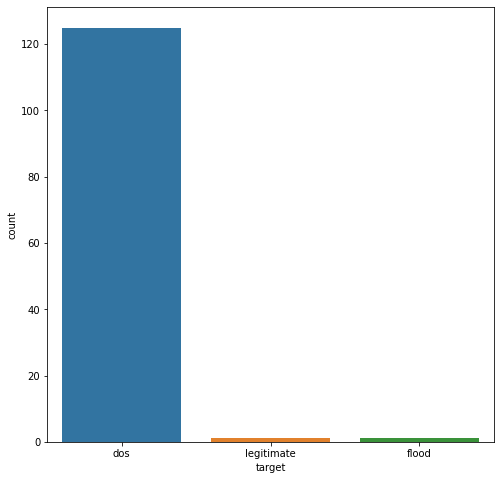

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
plt.figure( figsize = ( 8, 8 ) )

toplist= result.groupBy("target").count().sort("count",ascending=False).toPandas()
sns.barplot( x="target", y="count", data=toplist)
plt.show()

In [84]:
print("The most popular Target on Twitter is :")
toplist.iloc[0,:][0]

The most popular Target on Twitter is :


'dos'